#### Подготовка данных

In [1]:
import re
import json
import torch
import warnings
import string

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from datasets import Dataset
from transformers import AutoTokenizer
from transformers import AutoModelForSequenceClassification
from transformers import TrainingArguments, Trainer
from tqdm import tqdm
from tqdm.notebook import tqdm as tqdm2
from peft import LoraConfig, get_peft_model, prepare_model_for_kbit_training
from torchmetrics.classification import MultilabelF1Score, MultilabelAccuracy, MultilabelAUROC
from collections import Counter

tqdm2.pandas()
warnings.filterwarnings("ignore")

In [2]:
torch.cuda.empty_cache()

In [137]:

filename = "Русские_тексты_и_статистика_обучения_2020-2021\ТЕКСТЫ"
df = pd.read_csv(filename + "\learn_rus_20200901.csv", sep='\t', encoding='cp1251')
df = df.loc[df['RGNTI'].apply(lambda x: re.findall("\d+",x)!=[])] # Пропускаем строки без класса

In [138]:
df_test = pd.read_csv(filename + "\\test_rus_20200901.csv", sep='\t', encoding='cp1251',
                       error_bad_lines=False)
df_test = df_test.loc[df_test['RGNTI'].apply(lambda x: re.findall("\d+",x)!=[])]

b'Skipping line 23708: expected 8 fields, saw 9\n'


In [139]:
[re.findall("\d+.\d+",el)[0] for el in df['RGNTI'].iloc[0].split('\\')]

['87.29', '89.57', '89.57']

In [140]:
df['target'] = df['RGNTI'].apply(lambda x:
                                 list(set([re.findall("\d+",el)[0]
                                            for el in x.split('\\')]))) # Для каждой строки извлекаем значения ГРНТИ 1 уровня

df_test['target'] = df_test['RGNTI'].apply(lambda x:
                                 list(set([re.findall("\d+",el)[0]
                                            for el in x.split('\\')])))

In [141]:
df['target_2'] = df['RGNTI'].apply(lambda x:
                                 list(set([re.findall("\d+.\d+",el)[0]
                                            for el in x.split('\\')])))
df_test['target_2'] = df_test['RGNTI'].apply(lambda x:
                                 list(set([re.findall("\d+.\d+",el)[0]
                                            for el in x.split('\\')])))

In [142]:
df['target'].head(), df['target_2'].head()

(0    [87, 89]
 1        [47]
 2    [53, 81]
 3        [55]
 4        [31]
 Name: target, dtype: object,
 0    [89.57, 87.29]
 1           [47.05]
 2    [53.49, 81.33]
 3           [55.13]
 4           [31.21]
 Name: target_2, dtype: object)

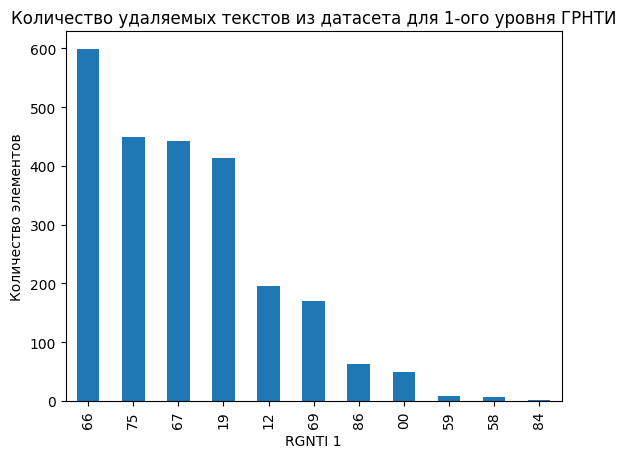

In [146]:
pd.value_counts(np.concatenate(df['target'].values))[-11:].plot.bar()
plt.xlabel("RGNTI 1")
plt.ylabel("Количество элементов")
plt.title("Количество удаляемых текстов из датасета для 1-ого уровня ГРНТИ");

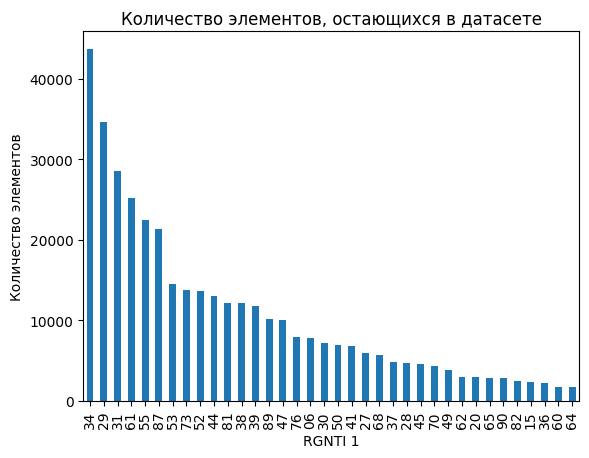

In [144]:
pd.value_counts(np.concatenate(df['target'].values))[:-11].plot.bar()
plt.xlabel("RGNTI 1")
plt.ylabel("Количество элементов")
plt.title("Количество элементов, остающихся в датасете");

In [145]:
#Убираем 11 классов, в которых меньше всего элементов.
list_of_few_values = pd.value_counts(np.concatenate(df['target'].values))[:-11].index.to_list() 
df_trunc = df.copy()
df_trunc['target'] = df['target'].apply(lambda x: list(set(x) & set(list_of_few_values)))
df_trunc = df_trunc[df_trunc['target'].apply(lambda x: x != []) ]

df_test_trunc = df_test.copy()
df_test_trunc["target"] = df_test['target'].apply(lambda x: list(set(x) & set(list_of_few_values)))



n_classes_trunc = len(np.unique(np.concatenate(df_trunc['target'].values)))
df_test_trunc["target"] = df_test_trunc["target"].apply(lambda x: x if x!=[] else ["no class"])
# df_test_trunc = df_test_trunc[df_test_trunc['target'].apply(lambda x: x != []) ]
# df_trunc
n_classes2 = len(np.unique(np.concatenate(df['target'].values))) # Количество классов изначально 
n_classes2

47

In [147]:
df.shape, df_test.shape, df_trunc.shape, df_test_trunc.shape

((293506, 10), (167003, 10), (292299, 10), (167003, 10))

In [148]:
unique_vals = np.unique(np.concatenate(df_trunc['target'].values))
unique_vals_test = np.unique(np.concatenate(df_test_trunc['target'].values))

In [149]:
len(unique_vals), len(unique_vals_test)

(36, 37)

In [150]:
list_of_proper_values_target_2 = []
list_of_inproper_values_target_2 = []

for target_2_val in tqdm(unique_vals):
    needed_taget2 = df_trunc['target_2'].apply(lambda x: [re.findall(f"{target_2_val}.\d+",el)[0] for el 
                                                 in x if re.findall(f"{target_2_val}.\d+",el)])
    concatenated_list_target2 = pd.value_counts(np.concatenate(np.array([el for el
                                                in needed_taget2.values.tolist() if el])))
    list_of_proper_values_target_2.extend(concatenated_list_target2[concatenated_list_target2 > 50].\
                                          index.to_list())
    list_of_inproper_values_target_2.extend(concatenated_list_target2[concatenated_list_target2 <= 50].\
                                          index.to_list())

100%|██████████| 36/36 [00:20<00:00,  1.79it/s]


In [151]:
set_of_proper_values_target_2 = set(list_of_proper_values_target_2)
df_trunc2 = df_trunc.copy()
df_trunc2['target_2'] = df_trunc['target_2'].apply(lambda x: list(set(x) &
                                                    set_of_proper_values_target_2))
df_trunc2 = df_trunc2[df_trunc2['target_2'].apply(lambda x: x != []) ]

df_test_trunc2 = df_test_trunc.copy()
# df_test_trunc2["target_2"] = df_test_trunc['target_2'].apply(lambda x: list(set(x) &
#                                                             set_of_proper_values_target_2))
# df_test_trunc2 = df_test_trunc2[df_test_trunc2['target_2'].apply(lambda x: x != []) ]



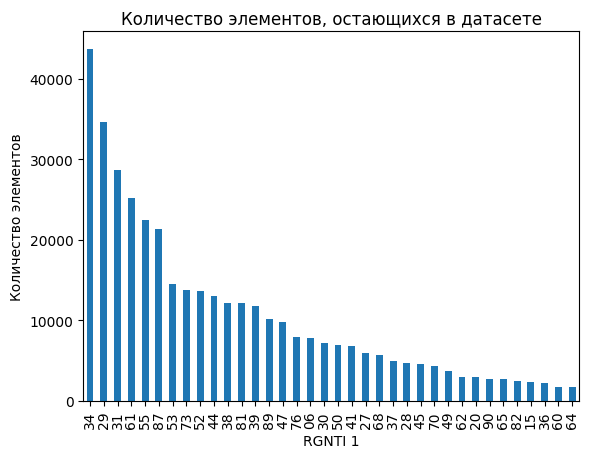

In [152]:
pd.value_counts(np.concatenate(df_trunc2['target'].values)).plot.bar()
plt.xlabel("RGNTI 1")
plt.ylabel("Количество элементов")
plt.title("Количество элементов, остающихся в датасете");

In [17]:
df_trunc2.shape, df_test_trunc2.shape

((291499, 10), (167003, 10))

In [18]:
len(np.unique(np.concatenate(df_trunc2['target'].values))),\
      len(np.unique(np.concatenate(df_test_trunc2['target'].values)))

(36, 37)

In [19]:
unique_vals, unique_vals_test

(array(['06', '15', '20', '27', '28', '29', '30', '31', '34', '36', '37',
        '38', '39', '41', '44', '45', '47', '49', '50', '52', '53', '55',
        '60', '61', '62', '64', '65', '68', '70', '73', '76', '81', '82',
        '87', '89', '90'], dtype='<U2'),
 array(['06', '15', '20', '27', '28', '29', '30', '31', '34', '36', '37',
        '38', '39', '41', '44', '45', '47', '49', '50', '52', '53', '55',
        '60', '61', '62', '64', '65', '68', '70', '73', '76', '81', '82',
        '87', '89', '90', 'no class'], dtype='<U8'))

In [20]:
np.random.seed(1234)
# np.random.shuffle(unique_vals)
# np.random.shuffle(unique_vals_test)

In [21]:
unique_vals_test, unique_vals

(array(['06', '15', '20', '27', '28', '29', '30', '31', '34', '36', '37',
        '38', '39', '41', '44', '45', '47', '49', '50', '52', '53', '55',
        '60', '61', '62', '64', '65', '68', '70', '73', '76', '81', '82',
        '87', '89', '90', 'no class'], dtype='<U8'),
 array(['06', '15', '20', '27', '28', '29', '30', '31', '34', '36', '37',
        '38', '39', '41', '44', '45', '47', '49', '50', '52', '53', '55',
        '60', '61', '62', '64', '65', '68', '70', '73', '76', '81', '82',
        '87', '89', '90'], dtype='<U2'))

In [22]:
# В тестовом датасете получилось на 1 класс больше, при тренировке мы про него информацию, 
# В тестовом датасете он будет далее представлен как список из нулевых значений
len(set(unique_vals)), len(set(unique_vals) | set(unique_vals_test)) 

(36, 37)

In [23]:
union_of_targets = set(unique_vals)
coding =  range(len(union_of_targets))
dict_Vinit_code_int = dict(zip(union_of_targets, coding))

In [24]:
#Создаем файл с кодами тренировочного классов тренировочного датасета 
with open("source/my_grnti1_int.json", "w") as outfile:
    json.dump(dict_Vinit_code_int, outfile)

In [25]:
grnti_mapping_dict = json.load(open('source\\my_grnti1_int.json')) # Загружаем файл с кодами 
n_classes = len(grnti_mapping_dict)
n_classes

36

In [26]:
grnti_mapping_dict

{'15': 0,
 '29': 1,
 '65': 2,
 '34': 3,
 '55': 4,
 '06': 5,
 '45': 6,
 '49': 7,
 '60': 8,
 '62': 9,
 '31': 10,
 '47': 11,
 '68': 12,
 '70': 13,
 '73': 14,
 '41': 15,
 '52': 16,
 '27': 17,
 '20': 18,
 '36': 19,
 '50': 20,
 '53': 21,
 '87': 22,
 '82': 23,
 '61': 24,
 '81': 25,
 '39': 26,
 '76': 27,
 '64': 28,
 '38': 29,
 '90': 30,
 '89': 31,
 '44': 32,
 '30': 33,
 '28': 34,
 '37': 35}

In [27]:
#Кодируем классы тренировочного датасета
df_trunc_result_multiclass_targets = []
for list_el in df_trunc2['target']:
    classes_zero = [0] * n_classes
    for index in list_el:
        if index in grnti_mapping_dict.keys():
            classes_zero[grnti_mapping_dict[index]] = 1

    df_trunc_result_multiclass_targets.append(classes_zero)

In [28]:
#Кодируем классы тестового датасета

df_test_trunc_result_multiclass_targets = []
for list_el in df_test_trunc2['target']:
    classes_zero = [0] * n_classes
    for index in list_el:
        if index in grnti_mapping_dict.keys():
            classes_zero[grnti_mapping_dict[index]] = 1

    df_test_trunc_result_multiclass_targets.append(classes_zero)

In [29]:
len(df_trunc_result_multiclass_targets), df_trunc2['target'].shape, len(df_test_trunc_result_multiclass_targets), df_test_trunc2['target'].shape

(291499, (291499,), 167003, (167003,))

In [30]:
df_trunc2['target_coded'] = df_trunc_result_multiclass_targets#df_trunc['target'].apply(lambda x: [grnti_mapping_dict[el] for el in x])
df_test_trunc2['target_coded'] = df_test_trunc_result_multiclass_targets #df_test_trunc['target'].apply(lambda x: [grnti_mapping_dict[el] for el in x] )

In [31]:
len(df_trunc2['target_coded'].iloc[0])

36

In [32]:
punct = [',', '.', '"', ':', ')', '(', '-', '!', '?', '|', ';', "'", '$', '&', '/', '[', ']', '>', '%', '=', '#', '*', '+', '\\', '•',  '~', '@', '£', 
 '·', '_', '{', '}', '©', '^', '®', '`',  '<', '→', '°', '€', '™', '›',  '♥', '←', '×', '§', '″', '′', 'Â', '█', '½', 'à', '…', 
 '“', '★', '”', '–', '●', 'â', '►', '−', '¢', '²', '¬', '░', '¶', '↑', '±', '¿', '▾', '═', '¦', '║', '―', '¥', '▓', '—', '‹', '─', 
 '▒', '：', '¼', '⊕', '▼', '▪', '†', '■', '’', '▀', '¨', '▄', '♫', '☆', 'é', '¯', '♦', '¤', '▲', 'è', '¸', '¾', 'Ã', '⋅', '‘', '∞', 
 '∙', '）', '↓', '、', '│', '（', '»', '，', '♪', '╩', '╚', '³', '・', '╦', '╣', '╔', '╗', '▬', '❤', 'ï', 'Ø', '¹', '≤', '‡', '√', ]

punct_mapping = {"‘": "'", "₹": "e", "´": "'", "°": "", "€": "e", "™": "tm", "√": " sqrt ", "×": "x", "²": "2", "—": "-", "–": "-", "’": "'", "_": "-",
                 "`": "'", '“': '"', '”': '"', '“': '"', "£": "e", '∞': 'infinity', 'θ': 'theta', '÷': '/', 'α': 'alpha', '•': '.', 'à': 'a', '−': '-', 
                 'β': 'beta', '∅': '', '³': '3', 'π': 'pi', '!':' '}

In [33]:
# Функции очистки текста, (возможно лучше без них, при очистке на one label классификации на одной эпохе лучше получались результаты)
def clean_text(text):
    ''' Make text lowercase, remove text in square brackets,remove links,remove punctuation
    and remove words containing numbers.'''
    text = re.sub(r'\:(.*?)\:','',text)
    text = str(text).lower()    #Making Text Lowercase
    text = re.sub('\[.*?\]', '', text)

    text = re.sub('\n', '', text)
    text = re.sub('\w*\d\w*', '', text)
    # replacing everything with space except (a-z, A-Z, ".", "?", "!", ",", "'")
    text = re.sub(r"[^а-яА-Я?.!,¿']+", " ", text)
    return text

def clean_contractions(text):
    specials = ["’", "‘", "´", "`"]
    for s in specials:
        text = text.replace(s, "'")
    #Remove Punctuations
    text = re.sub('[%s]' % re.escape(string.punctuation), '', text)
    # creating a space between a word and the punctuation following it
    # eg: "he is a boy." => "he is a boy ."
    text = re.sub(r"([?.!,¿])", r" \1 ", text)
    text = re.sub(r'[" "]+', " ", text)
    return text

def clean_special_chars(text, punct, mapping):
    '''Cleans special characters present(if any)'''   
    for p in mapping:
        text = text.replace(p, mapping[p])
    
    for p in punct:
        text = text.replace(p, f' {p} ')
    
    specials = {'\u200b': ' ', '…': ' ... ', '\ufeff': '', 'करना': '', 'है': ''}  
    for s in specials:
        text = text.replace(s, specials[s])
    
    return text

def remove_space(text):
    '''Removes awkward spaces'''   
    #Removes awkward spaces 
    text = text.strip()
    text = text.split()
    return " ".join(text)

def text_preprocessing_pipeline(text):
    '''Cleaning and parsing the text.'''
    text = clean_text(text)
    text = clean_contractions(text)
    text = clean_special_chars(text, punct, punct_mapping)
    text = remove_space(text)
    return text

In [34]:
df_trunc2['kw_list'].isna().sum(), df_trunc2['ref_txt'].isna().sum(), df_trunc2['title'].isna().sum()

(1495, 9, 0)

In [35]:
#Очистка столбца title
df_trunc2['cleaned_title'] = df_trunc2['title']#.progress_apply(text_preprocessing_pipeline)
df_test_trunc2['cleaned_title'] = df_test_trunc2['title']#.progress_apply(text_preprocessing_pipeline)

In [36]:
#Очистка столбца ref_txt
df_trunc2['cleaned_ref_txt'] = df_trunc2['ref_txt']#.progress_apply(lambda x: text_preprocessing_pipeline(str(x)))
df_test_trunc2['cleaned_ref_txt'] = df_test_trunc2['ref_txt']#.progress_apply(lambda x:
                                                                            #text_preprocessing_pipeline(str(x)))

In [37]:
#Очистка столбца kw_list

df_trunc2['cleaned_kw_list'] = df_trunc2['kw_list']#.progress_apply(lambda x: text_preprocessing_pipeline(str(x)))
df_test_trunc2['cleaned_kw_list'] = df_test_trunc2['kw_list']#.progress_apply(lambda x: 
                                                                           #text_preprocessing_pipeline(str(x)))

In [38]:
df_trunc2['cleaned_title'].iloc[2]

'Микроскопическое моделирование фазового поля под действием процессов старения на процессы осаждения сплава Ni[75]Al[15]Ti[10]'

In [39]:
df_trunc2['cleaned_kw_list'].head()

0    Урало-Заволжье\анализ динамики\ландшафты\нефте...
1    метровый диапазон\обнаружение сигналов\подвижн...
2    Ni[75]Al[15]Ti[10], моделирование выделения, к...
3    автоматизированное проектирование\обработка ме...
4    3-арил-\4,6-диарил-1,6-дигидро-\Кастаньоли_-Ку...
Name: cleaned_kw_list, dtype: object

In [40]:
#Соединяем cleaned_title и cleaned_ref_txt
df_trunc2['text'] = (df_trunc2['cleaned_title'].apply(lambda x:x+' [SEP] ') 
                    # if x[-1] in ('.', '!', '?') else x+'. [SEP]')\
                     + df_trunc2['cleaned_ref_txt'])
df_test_trunc2['text'] = (df_test_trunc2['title'].apply(lambda x:x+' [SEP] ')
                                                      # if x[-1] 
                                          # in ('.', '!', '?') else x+'. [SEP]')
                                            + df_test_trunc2['cleaned_ref_txt'])

In [41]:
#Соединяем text и cleaned_kw_list

# res_df_trunc = df_trunc['kw_list'].astype(str).apply(lambda x: 
#                                             ",".join(re.split(r'\\|,', x.strip())))
df_trunc2['text'] = (df_trunc2['text'].apply(lambda x:str(x)+' [SEP] ' ) + df_trunc2['cleaned_kw_list'])

# res_df_test_trunc= df_test_trunc['kw_list'].astype(str).apply(lambda x: 
#                                             ",".join(re.split(r'\\|,', x.strip())))
df_test_trunc2['text'] = df_test_trunc2['text'].apply(lambda x:str(x)+' [SEP] ') + df_test_trunc2['cleaned_kw_list']

In [42]:
df_trunc2['text'].iloc[0]

'Некоторые аспекты изменения степных ландшафтов Урало-Заволжья в условиях нефтегазодобычи [SEP] Предлагается результат анализа динамики некоторых составляющих степных ландшафтов Урало-Заволжья, находящихся под воздействием нефтегазодобычи, с использованием спутниковых данных. Оценены такие показатели, как облесенность и фрагментированность территории [SEP] Урало-Заволжье\\анализ динамики\\ландшафты\\нефтегазодобыча\\нефтегазоносность\\спутниковые данные\\спутниковые наблюдения\\степень облесенности\\степные\\фрагментированность территории\\экология'

In [43]:
df_trunc2 = df_trunc2.dropna(subset=['text'], axis=0)
df_test_trunc2 = df_test_trunc2.dropna(subset=['text'], axis=0)

In [44]:
df_trunc2 = df_trunc2[df_trunc2['text'].apply(lambda x: len(x.split()) > 10)]

In [45]:
df_trunc2.shape[0] / df.shape[0]

0.9880343161638945

In [46]:
df_trunc2['text'].head()

0    Некоторые аспекты изменения степных ландшафтов...
1    Подходы к повышению точности определения харак...
2    Микроскопическое моделирование фазового поля п...
3    МОДЕЛИ И МЕТОДИКИ АВТОМАТИЗАЦИИ ПРОЦЕДУР РАЗРА...
4    Трехкомпонентная реакция Кастагноли-Кушмана 3-...
Name: text, dtype: object

In [47]:
df_trunc2.shape, df_test_trunc2.shape

((289994, 15), (166183, 15))

In [48]:
df_trunc2.text.isna().sum(), df_test_trunc2.text.isna().sum()

(0, 0)

In [49]:
del df, df_test, df_trunc, df_test_trunc, df_trunc_result_multiclass_targets,\
      df_test_trunc_result_multiclass_targets

### Обучение с помощью Trainer


In [50]:
MAX_LEN=512
EPOCH = 5
BATCH_SIZE = 8
PRE_TRAINED_MODEL_NAME = 'DeepPavlov/rubert-base-cased'

In [51]:
tokenizer = AutoTokenizer.from_pretrained(PRE_TRAINED_MODEL_NAME, do_lower_case = True)


In [52]:
model = AutoModelForSequenceClassification.from_pretrained(PRE_TRAINED_MODEL_NAME,
                                                            problem_type="multi_label_classification",
                                                           num_labels=n_classes)
# model.resize_token_embeddings(len(tokenizer))

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at DeepPavlov/rubert-base-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [53]:
n_classes

36

In [54]:
# Новый токен
new_tokens = ["ии"]

# Проверяем, есть ли токены в словаре
new_tokens = set(new_tokens) - set(tokenizer.vocab.keys())

# Добавляем новые токены в словарь 
tokenizer.add_tokens(list(new_tokens))

# Добавляем новые случайные эмбэдинги для новых токенов
model.resize_token_embeddings(len(tokenizer))

Embedding(119548, 768)

In [55]:
model

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(119548, 768)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_a

In [56]:
from peft import TaskType

# lora для модели
config = LoraConfig(
    r=16,
    lora_alpha=32,
    lora_dropout=0.05,
    bias="none",
    task_type=TaskType.SEQ_CLS
)
# model = prepare_model_for_kbit_training(model)
model_peft = get_peft_model(model, config)

In [57]:
model_peft.print_trainable_parameters()

trainable params: 617,508 || all params: 178,499,400 || trainable%: 0.3459440199798991


In [58]:
sum(df_trunc2['target_coded'].iloc[15])

1

In [59]:
def tokenizing_for_bert(text):
    return tokenizer.encode_plus(
            text,
            max_length = MAX_LEN,
            return_tensors = 'pt',
            truncation=True,
            return_token_type_ids=True,
            return_attention_mask = True,
            padding = 'max_length')

In [60]:
# Ищем элемнты, c list из target_coded, который встречается только 1 раз
list_of_keys_less_than_two = []
for key, val in Counter(df_trunc2['target_coded'].apply(lambda x: str(x))).items():
    if val < 2:
        list_of_keys_less_than_two.append(key)

In [61]:
# Всего элементов c list из target_coded, который встречается только 1 раз
len(list_of_keys_less_than_two) 

135

In [62]:
#Отделяем элементы датасета c list из target_coded, который встречается только 1 раз
df_trunc_single_example = df_trunc2[df_trunc2['target_coded'].apply(lambda x: str(x) 
                                                                    in list_of_keys_less_than_two)]

In [63]:
df_trunc_no_less_than_two = df_trunc2[df_trunc2['target_coded'].apply(lambda x: str(x) 
                                                                    not in list_of_keys_less_than_two)]

In [64]:
# Создаем стратифицированную выборку для обучения и валидации
train_df_0, valid_df= train_test_split(df_trunc_no_less_than_two, 
                                     stratify=df_trunc_no_less_than_two['target_coded'].apply(lambda x: str(x)),
                                        test_size=0.2)

In [65]:
# Добавляем в обучающую выборку элементы начального датасета c list из target_coded, который встречается только 1 раз
train_df = pd.concat([train_df_0, df_trunc_single_example], ignore_index=True)
train_df_0.shape, df_trunc_single_example.shape, train_df.shape

((231887, 15), (135, 15), (232022, 15))

In [66]:
valid_df.shape[0] / (valid_df.shape[0] + train_df_0.shape[0])

0.20000068999065063

In [67]:
number_of_rows = train_df['target_coded'].shape[0]
number_per_class_1 = np.array([train_df['target_coded'].apply(lambda x: x[index]).sum() 
                             for index in range(n_classes)])
number_per_class_0 = np.array([train_df['target_coded'].apply(lambda x: not x[index]).sum() 
                             for index in range(n_classes)])
print(number_per_class_1)

# Cчитаем веса каждого классов
weights_per_class = number_of_rows / (number_per_class_1 * n_classes)
print(weights_per_class)


[ 1867 26489  2165 34927 17926  6300  3669  3019  1389  2369 22889  7867
  4524  3502 11016  5415 10903  4787  2361  1823  5526 11624 17124  1969
 20164  9677  9470  6338  1350  9670  2228  8100 10466  5713  3741  3916]
[3.45209189 0.24331064 2.97693097 0.18452932 0.35953674 1.02302469
 1.75662457 2.13483125 4.64006879 2.72058065 0.28157873 0.81925201
 1.42463651 1.84039279 0.58506314 1.19022263 0.59112681 1.34636632
 2.72979905 3.53541171 1.16631479 0.55446108 0.37637559 3.27326336
 0.3196318  0.66601793 0.68057609 1.01689106 4.77411523 0.66650006
 2.89275384 0.79568587 0.61580886 1.12813855 1.72281624 1.64582624]


In [68]:
# Cчитаем отношение нулевых элемнтов к позитивным для каждого из классов
pos_weight = torch.tensor(number_per_class_0 / number_per_class_1)

In [69]:
pos_weight

tensor([123.2753,   7.7592, 106.1695,   5.6431,  11.9433,  35.8289,  62.2385,
         75.8539, 166.0425,  96.9409,   9.1368,  28.4931,  50.2869,  65.2541,
         20.0623,  41.8480,  20.2806,  47.4692,  97.2728, 126.2748,  40.9873,
         18.9606,  12.5495, 116.8375,  10.5067,  22.9766,  23.5007,  35.6081,
        170.8681,  22.9940, 103.1391,  27.6447,  21.1691,  39.6130,  61.0214,
         58.2497], dtype=torch.float64)

In [70]:
# Токенизация 
input_ids_train = []
attention_masks_train = []
token_type_ids_train =[]
# Для каждого тектса...
for sent in tqdm(train_df['text']):
    encoded_dict = tokenizing_for_bert(sent)
    # Добавляем закодированный текст в list.
    input_ids_train.append(encoded_dict['input_ids'])
    # Добавляем attention mask (Отделяем padding от non-padding токенов).
    attention_masks_train.append(encoded_dict['attention_mask'])
    #Добавляем token_type_ids, тк у нас есть [SEP] в тексах 
    token_type_ids_train.append(encoded_dict['token_type_ids'])

# Переводим листы в тензоры.
input_ids_train = torch.cat(input_ids_train, dim=0)
attention_masks_train = torch.cat(attention_masks_train, dim=0)
token_type_ids_train = torch.cat(token_type_ids_train, dim=0)

100%|██████████| 232022/232022 [03:02<00:00, 1272.95it/s]


In [71]:
labels_train = torch.tensor(train_df['target_coded'].to_list()).float()

In [72]:
input_ids_validation = []
attention_masks_validation = []
token_type_ids_validation =[]

for sent in tqdm(valid_df['text']):
    encoded_dict = tokenizing_for_bert(sent)
    input_ids_validation.append(encoded_dict['input_ids'])
    attention_masks_validation.append(encoded_dict['attention_mask'])
    token_type_ids_validation.append(encoded_dict['token_type_ids'])

input_ids_validation = torch.cat(input_ids_validation, dim=0)
attention_masks_validation = torch.cat(attention_masks_validation, dim=0)
token_type_ids_validation = torch.cat(token_type_ids_validation, dim=0)

100%|██████████| 57972/57972 [00:53<00:00, 1078.11it/s]


In [73]:
labels_validation = torch.tensor(valid_df['target_coded'].to_list()).float()

In [74]:
input_ids_test = []
attention_masks_test = []
token_type_ids_test =[]

for sent in tqdm(df_test_trunc2['text']):
    encoded_dict = tokenizing_for_bert(sent)
    input_ids_test.append(encoded_dict['input_ids'])
    attention_masks_test.append(encoded_dict['attention_mask'])
    token_type_ids_test.append(encoded_dict['token_type_ids'])

input_ids_test = torch.cat(input_ids_test, dim=0)
attention_masks_test= torch.cat(attention_masks_test, dim=0)
token_type_ids_test = torch.cat(token_type_ids_test, dim=0)

100%|██████████| 166183/166183 [02:07<00:00, 1299.87it/s]


In [75]:
labels_test = torch.tensor(df_test_trunc2['target_coded'].to_list()).float()

In [76]:
labels_test.shape

torch.Size([166183, 36])

In [77]:
#Собираем датасеты и делаем shuffle для каждого
SEED = 1234
dataset_train_v2 = Dataset.from_dict({"input_ids":input_ids_train,  
                                      "attention_mask":attention_masks_train,  
                                      "labels":labels_train,
                                      "token_type_ids":token_type_ids_train}).shuffle(SEED)

dataset_valid_v2 = Dataset.from_dict({"input_ids":input_ids_validation,  
                                      "attention_mask":attention_masks_validation,  
                                      "labels":labels_validation,
                                      "token_type_ids":token_type_ids_validation}).shuffle(SEED)



In [78]:
dataset_test_v2 = Dataset.from_dict({"input_ids":input_ids_test,  
                                      "attention_mask":attention_masks_test,  
                                      "labels":labels_test,
                                      "token_type_ids":token_type_ids_test}).shuffle(SEED)

In [79]:
len(next(iter(dataset_test_v2))['labels'])

36

In [80]:
dataloader_test = torch.utils.data.DataLoader(dataset_test_v2, batch_size=BATCH_SIZE)

In [81]:
len(next(iter(dataloader_test))['labels'])

36

In [82]:
weights_per_class

array([3.45209189, 0.24331064, 2.97693097, 0.18452932, 0.35953674,
       1.02302469, 1.75662457, 2.13483125, 4.64006879, 2.72058065,
       0.28157873, 0.81925201, 1.42463651, 1.84039279, 0.58506314,
       1.19022263, 0.59112681, 1.34636632, 2.72979905, 3.53541171,
       1.16631479, 0.55446108, 0.37637559, 3.27326336, 0.3196318 ,
       0.66601793, 0.68057609, 1.01689106, 4.77411523, 0.66650006,
       2.89275384, 0.79568587, 0.61580886, 1.12813855, 1.72281624,
       1.64582624])

In [83]:
# Функции для подсчета метрик при валидации
multilabel_accuracy_micro = MultilabelAccuracy(num_labels=n_classes, average='micro')
multilabel_accuracy_macro = MultilabelAccuracy(num_labels=n_classes, average='macro')
multilabel_accuracy_weighted = MultilabelAccuracy(num_labels=n_classes, average='weighted')

multilabel_f1_score_micro = MultilabelF1Score(num_labels=n_classes, average='micro')
multilabel_f1_score_macro = MultilabelF1Score(num_labels=n_classes, average='macro')
multilabel_f1_score_weighted = MultilabelF1Score(num_labels=n_classes, average='weighted')

multilabel_f1_score_micro_06 = MultilabelF1Score(num_labels=n_classes, average='micro', 
                                                  threshold=0.6)
multilabel_f1_score_macro_06 = MultilabelF1Score(num_labels=n_classes, average='macro', 
                                                  threshold=0.6)
multilabel_f1_score_weighted_06 = MultilabelF1Score(num_labels=n_classes, average='weighted', 
                                                  threshold=0.6)

multilabel_f1_score_micro_07 = MultilabelF1Score(num_labels=n_classes, average='micro', 
                                                  threshold=0.7)
multilabel_f1_score_macro_07 = MultilabelF1Score(num_labels=n_classes, average='macro', 
                                                  threshold=0.7)
multilabel_f1_score_weighted_07 = MultilabelF1Score(num_labels=n_classes, average='weighted', 
                                                  threshold=0.7)

multilabel_f1_score_micro_08 = MultilabelF1Score(num_labels=n_classes, average='micro', 
                                                  threshold=0.8)
multilabel_f1_score_macro_08 = MultilabelF1Score(num_labels=n_classes, average='macro', 
                                                  threshold=0.8)
multilabel_f1_score_weighted_08 = MultilabelF1Score(num_labels=n_classes, average='weighted', 
                                                  threshold=0.8)

multilabel_f1_score_micro_09 = MultilabelF1Score(num_labels=n_classes, average='micro', 
                                                  threshold=0.9)
multilabel_f1_score_macro_09 = MultilabelF1Score(num_labels=n_classes, average='macro', 
                                                  threshold=0.9)
multilabel_f1_score_weighted_09 = MultilabelF1Score(num_labels=n_classes, average='weighted', 
                                                  threshold=0.9)


multilabel_auroc_micro =  MultilabelAUROC(num_labels=n_classes, average="micro", thresholds=5)
multilabel_auroc_macro =  MultilabelAUROC(num_labels=n_classes, average="macro", thresholds=5)
multilabel_auroc_weighted =  MultilabelAUROC(num_labels=n_classes, average="weighted", thresholds=5)

In [84]:
# Функция подсчета всех метрик при валидации
def compute_metrics(pred):
    labels = torch.tensor(pred.label_ids).int()
    preds = torch.sigmoid(torch.tensor(pred.predictions).float())# Принимем сигмоду для получения вероятностей

    accuracy_micro = multilabel_accuracy_micro(preds, labels)
    accuracy_macro = multilabel_accuracy_macro(preds, labels)
    accuracy_weighted = multilabel_accuracy_weighted(preds, labels)

    f1_micro = multilabel_f1_score_micro(preds, labels)
    f1_macro = multilabel_f1_score_macro(preds, labels)
    f1_weighted = multilabel_f1_score_weighted(preds, labels)

    f1_micro_06 = multilabel_f1_score_micro_06(preds, labels)
    f1_macro_06 = multilabel_f1_score_macro_06(preds, labels)
    f1_weighted_06 = multilabel_f1_score_weighted_06(preds, labels)

    f1_micro_07 = multilabel_f1_score_micro_07(preds, labels)
    f1_macro_07 = multilabel_f1_score_macro_07(preds, labels)
    f1_weighted_07 = multilabel_f1_score_weighted_07(preds, labels)

    f1_micro_08 = multilabel_f1_score_micro_08(preds, labels)
    f1_macro_08 = multilabel_f1_score_macro_08(preds, labels)
    f1_weighted_08 = multilabel_f1_score_weighted_08(preds, labels)

    f1_micro_09 = multilabel_f1_score_micro_09(preds, labels)
    f1_macro_09 = multilabel_f1_score_macro_09(preds, labels)
    f1_weighted_09 = multilabel_f1_score_weighted_09(preds, labels)

    aucroc_micro = multilabel_auroc_micro(preds, labels)
    aucroc_macro = multilabel_auroc_macro(preds, labels)
    aucroc_weighted = multilabel_auroc_weighted(preds, labels)

    return {
        'accuracy_micro_0.5': accuracy_micro,
        'accuracy_macro_0.5': accuracy_macro,
        'accuracy_weighted_0.5':accuracy_weighted,
        'f1_micro_0.5': f1_micro,
        'f1_macro_0.5': f1_macro,
        'f1_weighted_0.5': f1_weighted,

        'f1_micro_0.6': f1_micro_06,
        'f1_macro_0.6': f1_macro_06,
        'f1_weighted_0.6': f1_weighted_06,

        'f1_micro_0.7': f1_micro_07,
        'f1_macro_0.7': f1_macro_07,
        'f1_weighted_0.7': f1_weighted_07,
        
        'f1_micro_0.8': f1_micro_08,
        'f1_macro_0.8': f1_macro_08,
        'f1_weighted_0.8': f1_weighted_08,

        'f1_micro_0.9': f1_micro_09,
        'f1_macro_0.8': f1_macro_09,
        'f1_weighted_0.8': f1_weighted_09,

        "aucroc_micro": aucroc_micro, 
        "aucroc_macro": aucroc_macro, 
        "aucroc_weighted": aucroc_weighted
    }

In [85]:
#Папка для сохранения информации об обучении, валидации, сохранения моделей
DIR_NAME = "модель_bert_lora_no_preprocess_with_key_words_weighted_SEP_16_epoch_multilabel_shuffled_labels_trunc2_12"

In [86]:
#Функция потерь с учетом весов pos_weight для multilabel классификации (при pos_weight != 1 weight не учитывается)
loss_fuction_for_multiclass_classification =\
    torch.nn.BCEWithLogitsLoss(weight = torch.tensor(weights_per_class).float()).to("cuda")#pos_weight=pos_weight)

In [87]:
#Чтобы использовать собственную функцию потерь создаем класс CustomTrainer
class CustomTrainer(Trainer):
    def compute_loss(self, model, inputs, return_outputs=False):
        labels = inputs.pop("labels")
        outputs = model(**inputs)
        logits = outputs.logits
        loss = loss_fuction_for_multiclass_classification(logits, labels)

        return (loss, outputs) if return_outputs else loss

In [88]:
training_args = TrainingArguments(
    output_dir=DIR_NAME,          
    num_train_epochs=16,
    per_device_train_batch_size = BATCH_SIZE ,
    per_device_eval_batch_size = BATCH_SIZE,
    warmup_steps=10,
    logging_dir=DIR_NAME,
    weight_decay=1e-6,
    evaluation_strategy='epoch',
    save_strategy= "epoch",
    logging_strategy="steps",
    # save_steps=1000,
    # eval_steps=1000,
    # eval_steps=13000,
    logging_steps = 100,
    load_best_model_at_end=True,
    save_total_limit=2,
    report_to='tensorboard',
    overwrite_output_dir = True,
    save_safetensors = False,
    fp16=True,
    # dataloader_num_workers=0,
    optim="adamw_bnb_8bit"
)

In [89]:
# Create the Trainer instance
trainer = CustomTrainer(
    model=model_peft,
    args=training_args,
    train_dataset=dataset_train_v2,
    eval_dataset=dataset_valid_v2,
    compute_metrics=compute_metrics
)

In [90]:
torch.cuda.empty_cache()

In [91]:
#Обучение
history = trainer.train()

  0%|          | 0/464048 [00:00<?, ?it/s]

{'loss': 0.5987, 'grad_norm': 0.4491565227508545, 'learning_rate': 4.9990410268124596e-05, 'epoch': 0.0}
{'loss': 0.1464, 'grad_norm': 0.2961239814758301, 'learning_rate': 4.9979635288489306e-05, 'epoch': 0.01}
{'loss': 0.1334, 'grad_norm': 0.27185124158859253, 'learning_rate': 4.996886030885402e-05, 'epoch': 0.01}
{'loss': 0.1293, 'grad_norm': 0.38133639097213745, 'learning_rate': 4.9958085329218726e-05, 'epoch': 0.01}
{'loss': 0.1324, 'grad_norm': 0.3802551329135895, 'learning_rate': 4.994731034958344e-05, 'epoch': 0.02}
{'loss': 0.1277, 'grad_norm': 0.2576870024204254, 'learning_rate': 4.993653536994815e-05, 'epoch': 0.02}
{'loss': 0.1282, 'grad_norm': 0.16600771248340607, 'learning_rate': 4.992576039031286e-05, 'epoch': 0.02}
{'loss': 0.1254, 'grad_norm': 0.5234084129333496, 'learning_rate': 4.991498541067758e-05, 'epoch': 0.03}
{'loss': 0.1325, 'grad_norm': 0.3789934515953064, 'learning_rate': 4.990421043104228e-05, 'epoch': 0.03}
{'loss': 0.1349, 'grad_norm': 0.2471359521150589, 

  0%|          | 0/7247 [00:00<?, ?it/s]

{'eval_loss': 0.04756392166018486, 'eval_accuracy_micro_0.5': 0.9791048765182495, 'eval_accuracy_macro_0.5': 0.9791048765182495, 'eval_accuracy_weighted_0.5': 0.9664069414138794, 'eval_f1_micro_0.5': 0.6641973853111267, 'eval_f1_macro_0.5': 0.5939903855323792, 'eval_f1_weighted_0.5': 0.6295586228370667, 'eval_f1_micro_0.6': 0.618891716003418, 'eval_f1_macro_0.6': 0.5367218255996704, 'eval_f1_weighted_0.6': 0.5679662823677063, 'eval_f1_micro_0.7': 0.5469598770141602, 'eval_f1_macro_0.7': 0.45421117544174194, 'eval_f1_weighted_0.7': 0.483205109834671, 'eval_f1_micro_0.8': 0.43280893564224243, 'eval_f1_macro_0.8': 0.2073967456817627, 'eval_f1_weighted_0.8': 0.20493826270103455, 'eval_f1_micro_0.9': 0.24903379380702972, 'eval_aucroc_micro': 0.8767241835594177, 'eval_aucroc_macro': 0.8608002066612244, 'eval_aucroc_weighted': 0.8710112571716309, 'eval_runtime': 664.8388, 'eval_samples_per_second': 87.197, 'eval_steps_per_second': 10.9, 'epoch': 1.0}
{'loss': 0.0525, 'grad_norm': 0.4146761000

  0%|          | 0/7247 [00:00<?, ?it/s]

{'eval_loss': 0.03641396760940552, 'eval_accuracy_micro_0.5': 0.9833899736404419, 'eval_accuracy_macro_0.5': 0.9833899736404419, 'eval_accuracy_weighted_0.5': 0.9728111028671265, 'eval_f1_micro_0.5': 0.7496804594993591, 'eval_f1_macro_0.5': 0.7231724262237549, 'eval_f1_weighted_0.5': 0.7351141571998596, 'eval_f1_micro_0.6': 0.7251861691474915, 'eval_f1_macro_0.6': 0.6865296959877014, 'eval_f1_weighted_0.6': 0.7005383968353271, 'eval_f1_micro_0.7': 0.6841207146644592, 'eval_f1_macro_0.7': 0.6359800100326538, 'eval_f1_weighted_0.7': 0.6474202275276184, 'eval_f1_micro_0.8': 0.6105479001998901, 'eval_f1_macro_0.8': 0.42253556847572327, 'eval_f1_weighted_0.8': 0.39927852153778076, 'eval_f1_micro_0.9': 0.4572133719921112, 'eval_aucroc_micro': 0.9048351645469666, 'eval_aucroc_macro': 0.8982178568840027, 'eval_aucroc_weighted': 0.901456892490387, 'eval_runtime': 696.9326, 'eval_samples_per_second': 83.182, 'eval_steps_per_second': 10.398, 'epoch': 2.0}
{'loss': 0.0446, 'grad_norm': 0.468744397

  0%|          | 0/7247 [00:00<?, ?it/s]

{'eval_loss': 0.03218723088502884, 'eval_accuracy_micro_0.5': 0.9852869510650635, 'eval_accuracy_macro_0.5': 0.9852868914604187, 'eval_accuracy_weighted_0.5': 0.9757237434387207, 'eval_f1_micro_0.5': 0.7857102751731873, 'eval_f1_macro_0.5': 0.774979829788208, 'eval_f1_weighted_0.5': 0.7809783220291138, 'eval_f1_micro_0.6': 0.773332953453064, 'eval_f1_macro_0.6': 0.7576647996902466, 'eval_f1_weighted_0.6': 0.7639725804328918, 'eval_f1_micro_0.7': 0.7472435235977173, 'eval_f1_macro_0.7': 0.72374427318573, 'eval_f1_weighted_0.7': 0.7308156490325928, 'eval_f1_micro_0.8': 0.6961906552314758, 'eval_f1_macro_0.8': 0.5434762239456177, 'eval_f1_weighted_0.8': 0.5288772583007812, 'eval_f1_micro_0.9': 0.5796900391578674, 'eval_aucroc_micro': 0.9209920167922974, 'eval_aucroc_macro': 0.9168750047683716, 'eval_aucroc_weighted': 0.9177719950675964, 'eval_runtime': 701.9946, 'eval_samples_per_second': 82.582, 'eval_steps_per_second': 10.323, 'epoch': 3.0}
{'loss': 0.0341, 'grad_norm': 0.31895846128463

  0%|          | 0/7247 [00:00<?, ?it/s]

{'eval_loss': 0.02964489720761776, 'eval_accuracy_micro_0.5': 0.986636757850647, 'eval_accuracy_macro_0.5': 0.986636757850647, 'eval_accuracy_weighted_0.5': 0.978243887424469, 'eval_f1_micro_0.5': 0.805335521697998, 'eval_f1_macro_0.5': 0.7975437641143799, 'eval_f1_weighted_0.5': 0.8008151054382324, 'eval_f1_micro_0.6': 0.7928308248519897, 'eval_f1_macro_0.6': 0.7864398956298828, 'eval_f1_weighted_0.6': 0.7843576073646545, 'eval_f1_micro_0.7': 0.7689783573150635, 'eval_f1_macro_0.7': 0.7631061673164368, 'eval_f1_weighted_0.7': 0.7546913027763367, 'eval_f1_micro_0.8': 0.7237647175788879, 'eval_f1_macro_0.8': 0.6119619607925415, 'eval_f1_weighted_0.8': 0.5772939920425415, 'eval_f1_micro_0.9': 0.6169204711914062, 'eval_aucroc_micro': 0.9269075989723206, 'eval_aucroc_macro': 0.9288678765296936, 'eval_aucroc_weighted': 0.9248695969581604, 'eval_runtime': 643.8151, 'eval_samples_per_second': 90.044, 'eval_steps_per_second': 11.256, 'epoch': 4.0}
{'loss': 0.0291, 'grad_norm': 0.37364983558654

  0%|          | 0/7247 [00:00<?, ?it/s]

{'eval_loss': 0.027387792244553566, 'eval_accuracy_micro_0.5': 0.9875203371047974, 'eval_accuracy_macro_0.5': 0.9875203371047974, 'eval_accuracy_weighted_0.5': 0.979728102684021, 'eval_f1_micro_0.5': 0.8193865418434143, 'eval_f1_macro_0.5': 0.8123750686645508, 'eval_f1_weighted_0.5': 0.8161784410476685, 'eval_f1_micro_0.6': 0.8107448816299438, 'eval_f1_macro_0.6': 0.8026944398880005, 'eval_f1_weighted_0.6': 0.8048861622810364, 'eval_f1_micro_0.7': 0.7910264134407043, 'eval_f1_macro_0.7': 0.7819139361381531, 'eval_f1_weighted_0.7': 0.7812805771827698, 'eval_f1_micro_0.8': 0.7522310614585876, 'eval_f1_macro_0.8': 0.6431365609169006, 'eval_f1_weighted_0.8': 0.6260166168212891, 'eval_f1_micro_0.9': 0.6597143411636353, 'eval_aucroc_micro': 0.9321825504302979, 'eval_aucroc_macro': 0.9304900765419006, 'eval_aucroc_weighted': 0.9300522208213806, 'eval_runtime': 644.6113, 'eval_samples_per_second': 89.933, 'eval_steps_per_second': 11.242, 'epoch': 5.0}
{'loss': 0.0282, 'grad_norm': 0.2165604382

  0%|          | 0/7247 [00:00<?, ?it/s]

{'eval_loss': 0.026303887367248535, 'eval_accuracy_micro_0.5': 0.9880037903785706, 'eval_accuracy_macro_0.5': 0.9880037903785706, 'eval_accuracy_weighted_0.5': 0.9805886745452881, 'eval_f1_micro_0.5': 0.8281084895133972, 'eval_f1_macro_0.5': 0.8210289478302002, 'eval_f1_weighted_0.5': 0.8249546885490417, 'eval_f1_micro_0.6': 0.8210694789886475, 'eval_f1_macro_0.6': 0.813201904296875, 'eval_f1_weighted_0.6': 0.815287709236145, 'eval_f1_micro_0.7': 0.8035358190536499, 'eval_f1_macro_0.7': 0.7943094372749329, 'eval_f1_weighted_0.7': 0.7938479781150818, 'eval_f1_micro_0.8': 0.7699141502380371, 'eval_f1_macro_0.8': 0.6747590899467468, 'eval_f1_weighted_0.8': 0.6574030518531799, 'eval_f1_micro_0.9': 0.6901524662971497, 'eval_aucroc_micro': 0.9371486306190491, 'eval_aucroc_macro': 0.9356937408447266, 'eval_aucroc_weighted': 0.9350196719169617, 'eval_runtime': 637.5525, 'eval_samples_per_second': 90.929, 'eval_steps_per_second': 11.367, 'epoch': 6.0}
{'loss': 0.0263, 'grad_norm': 0.26016941666

  0%|          | 0/7247 [00:00<?, ?it/s]

{'eval_loss': 0.025109559297561646, 'eval_accuracy_micro_0.5': 0.9885739684104919, 'eval_accuracy_macro_0.5': 0.9885739684104919, 'eval_accuracy_weighted_0.5': 0.9813845753669739, 'eval_f1_micro_0.5': 0.8354358673095703, 'eval_f1_macro_0.5': 0.8303256630897522, 'eval_f1_weighted_0.5': 0.8322635889053345, 'eval_f1_micro_0.6': 0.8272907733917236, 'eval_f1_macro_0.6': 0.8216515183448792, 'eval_f1_weighted_0.6': 0.821540892124176, 'eval_f1_micro_0.7': 0.8097043037414551, 'eval_f1_macro_0.7': 0.8030397295951843, 'eval_f1_weighted_0.7': 0.8001216053962708, 'eval_f1_micro_0.8': 0.7787747383117676, 'eval_f1_macro_0.8': 0.6930314302444458, 'eval_f1_weighted_0.8': 0.6744347810745239, 'eval_f1_micro_0.9': 0.705237090587616, 'eval_aucroc_micro': 0.9383205771446228, 'eval_aucroc_macro': 0.9375972747802734, 'eval_aucroc_weighted': 0.936375617980957, 'eval_runtime': 639.9058, 'eval_samples_per_second': 90.595, 'eval_steps_per_second': 11.325, 'epoch': 7.0}
{'loss': 0.0248, 'grad_norm': 0.428851872682

  0%|          | 0/7247 [00:00<?, ?it/s]

{'eval_loss': 0.024494530633091927, 'eval_accuracy_micro_0.5': 0.9888700842857361, 'eval_accuracy_macro_0.5': 0.9888700246810913, 'eval_accuracy_weighted_0.5': 0.9819339513778687, 'eval_f1_micro_0.5': 0.8411130309104919, 'eval_f1_macro_0.5': 0.8368657827377319, 'eval_f1_weighted_0.5': 0.839711606502533, 'eval_f1_micro_0.6': 0.835634171962738, 'eval_f1_macro_0.6': 0.830897867679596, 'eval_f1_weighted_0.6': 0.8323734998703003, 'eval_f1_micro_0.7': 0.8214390873908997, 'eval_f1_macro_0.7': 0.8166435360908508, 'eval_f1_weighted_0.7': 0.815619170665741, 'eval_f1_micro_0.8': 0.7927280068397522, 'eval_f1_macro_0.8': 0.7187837958335876, 'eval_f1_weighted_0.8': 0.7030129432678223, 'eval_f1_micro_0.9': 0.7240484356880188, 'eval_aucroc_micro': 0.9414733052253723, 'eval_aucroc_macro': 0.9406693577766418, 'eval_aucroc_weighted': 0.9396150708198547, 'eval_runtime': 645.9609, 'eval_samples_per_second': 89.745, 'eval_steps_per_second': 11.219, 'epoch': 8.0}
{'loss': 0.0248, 'grad_norm': 0.1883030384778

  0%|          | 0/7247 [00:00<?, ?it/s]

{'eval_loss': 0.02368267998099327, 'eval_accuracy_micro_0.5': 0.9891940355300903, 'eval_accuracy_macro_0.5': 0.9891939759254456, 'eval_accuracy_weighted_0.5': 0.9824038743972778, 'eval_f1_micro_0.5': 0.8461706638336182, 'eval_f1_macro_0.5': 0.8424444198608398, 'eval_f1_weighted_0.5': 0.8443658351898193, 'eval_f1_micro_0.6': 0.8411363959312439, 'eval_f1_macro_0.6': 0.8367877006530762, 'eval_f1_weighted_0.6': 0.8375294804573059, 'eval_f1_micro_0.7': 0.8276204466819763, 'eval_f1_macro_0.7': 0.8228981494903564, 'eval_f1_weighted_0.7': 0.8216033577919006, 'eval_f1_micro_0.8': 0.8003972768783569, 'eval_f1_macro_0.8': 0.7310463190078735, 'eval_f1_weighted_0.8': 0.7148464322090149, 'eval_f1_micro_0.9': 0.7357667088508606, 'eval_aucroc_micro': 0.9436172246932983, 'eval_aucroc_macro': 0.9427909851074219, 'eval_aucroc_weighted': 0.9418964982032776, 'eval_runtime': 671.3959, 'eval_samples_per_second': 86.345, 'eval_steps_per_second': 10.794, 'epoch': 9.0}
{'loss': 0.0208, 'grad_norm': 0.3089460134

  0%|          | 0/7247 [00:00<?, ?it/s]

{'eval_loss': 0.02345186099410057, 'eval_accuracy_micro_0.5': 0.9892922639846802, 'eval_accuracy_macro_0.5': 0.989292323589325, 'eval_accuracy_weighted_0.5': 0.9826194047927856, 'eval_f1_micro_0.5': 0.8471696972846985, 'eval_f1_macro_0.5': 0.8441139459609985, 'eval_f1_weighted_0.5': 0.8455390334129333, 'eval_f1_micro_0.6': 0.8404584527015686, 'eval_f1_macro_0.6': 0.8374620676040649, 'eval_f1_weighted_0.6': 0.8369824886322021, 'eval_f1_micro_0.7': 0.8277334570884705, 'eval_f1_macro_0.7': 0.8258742690086365, 'eval_f1_weighted_0.7': 0.8217399716377258, 'eval_f1_micro_0.8': 0.8018772602081299, 'eval_f1_macro_0.8': 0.7389193177223206, 'eval_f1_weighted_0.8': 0.7174298167228699, 'eval_f1_micro_0.9': 0.7391524910926819, 'eval_aucroc_micro': 0.9432803988456726, 'eval_aucroc_macro': 0.9437405467033386, 'eval_aucroc_weighted': 0.9416455626487732, 'eval_runtime': 647.5067, 'eval_samples_per_second': 89.531, 'eval_steps_per_second': 11.192, 'epoch': 10.0}
{'loss': 0.0204, 'grad_norm': 0.5544734597

  0%|          | 0/7247 [00:00<?, ?it/s]

{'eval_loss': 0.022733984515070915, 'eval_accuracy_micro_0.5': 0.9896309971809387, 'eval_accuracy_macro_0.5': 0.9896309971809387, 'eval_accuracy_weighted_0.5': 0.9831388592720032, 'eval_f1_micro_0.5': 0.8527029156684875, 'eval_f1_macro_0.5': 0.8492788672447205, 'eval_f1_weighted_0.5': 0.8508973121643066, 'eval_f1_micro_0.6': 0.8479183912277222, 'eval_f1_macro_0.6': 0.8444881439208984, 'eval_f1_weighted_0.6': 0.8444908857345581, 'eval_f1_micro_0.7': 0.8365379571914673, 'eval_f1_macro_0.7': 0.832577645778656, 'eval_f1_weighted_0.7': 0.8307638168334961, 'eval_f1_micro_0.8': 0.8127169609069824, 'eval_f1_macro_0.8': 0.7515084147453308, 'eval_f1_weighted_0.8': 0.7360448241233826, 'eval_f1_micro_0.9': 0.7551873326301575, 'eval_aucroc_micro': 0.9459660053253174, 'eval_aucroc_macro': 0.9456153512001038, 'eval_aucroc_weighted': 0.9443573951721191, 'eval_runtime': 647.1535, 'eval_samples_per_second': 89.58, 'eval_steps_per_second': 11.198, 'epoch': 11.0}
{'loss': 0.0204, 'grad_norm': 0.1627377271

  0%|          | 0/7247 [00:00<?, ?it/s]

{'eval_loss': 0.022746147587895393, 'eval_accuracy_micro_0.5': 0.9897311329841614, 'eval_accuracy_macro_0.5': 0.9897311925888062, 'eval_accuracy_weighted_0.5': 0.9833637475967407, 'eval_f1_micro_0.5': 0.8539037704467773, 'eval_f1_macro_0.5': 0.8512167930603027, 'eval_f1_weighted_0.5': 0.8520540595054626, 'eval_f1_micro_0.6': 0.849288284778595, 'eval_f1_macro_0.6': 0.8471839427947998, 'eval_f1_weighted_0.6': 0.8457933068275452, 'eval_f1_micro_0.7': 0.837375283241272, 'eval_f1_macro_0.7': 0.8357442617416382, 'eval_f1_weighted_0.7': 0.8315876722335815, 'eval_f1_micro_0.8': 0.8136146068572998, 'eval_f1_macro_0.8': 0.7592768669128418, 'eval_f1_weighted_0.8': 0.7386589646339417, 'eval_f1_micro_0.9': 0.7576160430908203, 'eval_aucroc_micro': 0.9461478590965271, 'eval_aucroc_macro': 0.9470141530036926, 'eval_aucroc_weighted': 0.9446227550506592, 'eval_runtime': 670.686, 'eval_samples_per_second': 86.437, 'eval_steps_per_second': 10.805, 'epoch': 12.0}
{'loss': 0.0256, 'grad_norm': 0.14991870522

  0%|          | 0/7247 [00:00<?, ?it/s]

{'eval_loss': 0.02238028310239315, 'eval_accuracy_micro_0.5': 0.9897757172584534, 'eval_accuracy_macro_0.5': 0.9897757172584534, 'eval_accuracy_weighted_0.5': 0.9832230806350708, 'eval_f1_micro_0.5': 0.8544752597808838, 'eval_f1_macro_0.5': 0.8536868691444397, 'eval_f1_weighted_0.5': 0.8533124923706055, 'eval_f1_micro_0.6': 0.8490779399871826, 'eval_f1_macro_0.6': 0.8490335941314697, 'eval_f1_weighted_0.6': 0.8463873863220215, 'eval_f1_micro_0.7': 0.8370808959007263, 'eval_f1_macro_0.7': 0.8379718065261841, 'eval_f1_weighted_0.7': 0.8321942687034607, 'eval_f1_micro_0.8': 0.8126688003540039, 'eval_f1_macro_0.8': 0.760918378829956, 'eval_f1_weighted_0.8': 0.7382177114486694, 'eval_f1_micro_0.9': 0.7548006176948547, 'eval_aucroc_micro': 0.9464904069900513, 'eval_aucroc_macro': 0.9471144080162048, 'eval_aucroc_weighted': 0.9449910521507263, 'eval_runtime': 660.665, 'eval_samples_per_second': 87.748, 'eval_steps_per_second': 10.969, 'epoch': 13.0}
{'loss': 0.0219, 'grad_norm': 0.52253186702

  0%|          | 0/7247 [00:00<?, ?it/s]

{'eval_loss': 0.022118736058473587, 'eval_accuracy_micro_0.5': 0.9899486899375916, 'eval_accuracy_macro_0.5': 0.9899487495422363, 'eval_accuracy_weighted_0.5': 0.9836312532424927, 'eval_f1_micro_0.5': 0.8572653532028198, 'eval_f1_macro_0.5': 0.8554459810256958, 'eval_f1_weighted_0.5': 0.8559327125549316, 'eval_f1_micro_0.6': 0.8527461290359497, 'eval_f1_macro_0.6': 0.8514329195022583, 'eval_f1_weighted_0.6': 0.849880039691925, 'eval_f1_micro_0.7': 0.8415653109550476, 'eval_f1_macro_0.7': 0.8404415845870972, 'eval_f1_weighted_0.7': 0.8366745114326477, 'eval_f1_micro_0.8': 0.8188402056694031, 'eval_f1_macro_0.8': 0.7663344740867615, 'eval_f1_weighted_0.8': 0.7478475570678711, 'eval_f1_micro_0.9': 0.7645128965377808, 'eval_aucroc_micro': 0.9475235939025879, 'eval_aucroc_macro': 0.9476912021636963, 'eval_aucroc_weighted': 0.9459984302520752, 'eval_runtime': 631.5427, 'eval_samples_per_second': 91.794, 'eval_steps_per_second': 11.475, 'epoch': 14.0}
{'loss': 0.0197, 'grad_norm': 0.224706888

  0%|          | 0/7247 [00:00<?, ?it/s]

{'eval_loss': 0.02222108654677868, 'eval_accuracy_micro_0.5': 0.9899367094039917, 'eval_accuracy_macro_0.5': 0.9899366497993469, 'eval_accuracy_weighted_0.5': 0.9836010932922363, 'eval_f1_micro_0.5': 0.8574918508529663, 'eval_f1_macro_0.5': 0.8561734557151794, 'eval_f1_weighted_0.5': 0.856457531452179, 'eval_f1_micro_0.6': 0.8530670404434204, 'eval_f1_macro_0.6': 0.8518780469894409, 'eval_f1_weighted_0.6': 0.8505191206932068, 'eval_f1_micro_0.7': 0.8428845405578613, 'eval_f1_macro_0.7': 0.8438063859939575, 'eval_f1_weighted_0.7': 0.8385657072067261, 'eval_f1_micro_0.8': 0.8212413787841797, 'eval_f1_macro_0.8': 0.7738824486732483, 'eval_f1_weighted_0.8': 0.7522324323654175, 'eval_f1_micro_0.9': 0.7672039270401001, 'eval_aucroc_micro': 0.9482426643371582, 'eval_aucroc_macro': 0.9490431547164917, 'eval_aucroc_weighted': 0.946771502494812, 'eval_runtime': 642.6369, 'eval_samples_per_second': 90.21, 'eval_steps_per_second': 11.277, 'epoch': 15.0}
{'loss': 0.022, 'grad_norm': 0.3178639709949

  0%|          | 0/7247 [00:00<?, ?it/s]

{'eval_loss': 0.02205066941678524, 'eval_accuracy_micro_0.5': 0.9900416731834412, 'eval_accuracy_macro_0.5': 0.9900416135787964, 'eval_accuracy_weighted_0.5': 0.9838002920150757, 'eval_f1_micro_0.5': 0.8588715195655823, 'eval_f1_macro_0.5': 0.857103168964386, 'eval_f1_weighted_0.5': 0.857482373714447, 'eval_f1_micro_0.6': 0.8543738126754761, 'eval_f1_macro_0.6': 0.8528296947479248, 'eval_f1_weighted_0.6': 0.8515394330024719, 'eval_f1_micro_0.7': 0.8442281484603882, 'eval_f1_macro_0.7': 0.8442474007606506, 'eval_f1_weighted_0.7': 0.8395009636878967, 'eval_f1_micro_0.8': 0.8231480717658997, 'eval_f1_macro_0.8': 0.775233805179596, 'eval_f1_weighted_0.8': 0.7548574209213257, 'eval_f1_micro_0.9': 0.7706882953643799, 'eval_aucroc_micro': 0.9487583041191101, 'eval_aucroc_macro': 0.9491043090820312, 'eval_aucroc_weighted': 0.9472560286521912, 'eval_runtime': 650.9995, 'eval_samples_per_second': 89.051, 'eval_steps_per_second': 11.132, 'epoch': 16.0}
{'train_runtime': 111637.8475, 'train_sample

In [92]:
model_peft.to("cpu")
model_peft.save_pretrained("модель_bert_lora_no_preprocess_with_key"\
                                        "_words_weighted_SEP_16_epoch_multilabel"\
                                        "_shuffled_labels_trunc2_12"\
                                        "_experiment_save_peft")
tokenizer.save_pretrained("модель_bert_lora_no_preprocess_with_key"\
                                        "_words_weighted_SEP_16_epoch_multilabel"\
                                        "_shuffled_labels_trunc2_12"\
                                        "_experiment_save_peft")

('модель_bert_lora_no_preprocess_with_key_words_weighted_SEP_16_epoch_multilabel_shuffled_labels_trunc2_12_experiment_save_peft\\tokenizer_config.json',
 'модель_bert_lora_no_preprocess_with_key_words_weighted_SEP_16_epoch_multilabel_shuffled_labels_trunc2_12_experiment_save_peft\\special_tokens_map.json',
 'модель_bert_lora_no_preprocess_with_key_words_weighted_SEP_16_epoch_multilabel_shuffled_labels_trunc2_12_experiment_save_peft\\vocab.txt',
 'модель_bert_lora_no_preprocess_with_key_words_weighted_SEP_16_epoch_multilabel_shuffled_labels_trunc2_12_experiment_save_peft\\added_tokens.json',
 'модель_bert_lora_no_preprocess_with_key_words_weighted_SEP_16_epoch_multilabel_shuffled_labels_trunc2_12_experiment_save_peft\\tokenizer.json')

In [93]:
# merge весов их сохранение 
merged_model_multilabel = model_peft.merge_and_unload()

merged_model_multilabel.save_pretrained("модель_bert_lora_no_preprocess_with_key"\
                                        "_words_weighted_SEP_16_epoch_multilabel"\
                                        "_shuffled_labels_trunc2_12"\
                                        "_experiment_save")
tokenizer.save_pretrained("модель_bert_lora_no_preprocess_with_key"\
                                        "_words_weighted_SEP_16_epoch_multilabel"\
                                        "_shuffled_labels_trunc2_12"\
                                        "_experiment_save")


# torch.save(merged_model_multilabel.state_dict(),
#            "модель_bert_lora_no_preprocess_with_key_words_weighted_SEP_12_epoch_multilabel_shuffled_labels_trunc2_11.pth")

('модель_bert_lora_no_preprocess_with_key_words_weighted_SEP_16_epoch_multilabel_shuffled_labels_trunc2_12_experiment_save\\tokenizer_config.json',
 'модель_bert_lora_no_preprocess_with_key_words_weighted_SEP_16_epoch_multilabel_shuffled_labels_trunc2_12_experiment_save\\special_tokens_map.json',
 'модель_bert_lora_no_preprocess_with_key_words_weighted_SEP_16_epoch_multilabel_shuffled_labels_trunc2_12_experiment_save\\vocab.txt',
 'модель_bert_lora_no_preprocess_with_key_words_weighted_SEP_16_epoch_multilabel_shuffled_labels_trunc2_12_experiment_save\\added_tokens.json',
 'модель_bert_lora_no_preprocess_with_key_words_weighted_SEP_16_epoch_multilabel_shuffled_labels_trunc2_12_experiment_save\\tokenizer.json')

In [94]:
model_peft.to("cuda");


In [95]:
res_evaluate = trainer.evaluate(dataset_test_v2) # применние compute_metrics к тестовому датасету.

  0%|          | 0/20773 [00:00<?, ?it/s]

In [96]:
res_evaluate

{'eval_loss': 0.02533254213631153,
 'eval_accuracy_micro_0.5': 0.9894002676010132,
 'eval_accuracy_macro_0.5': 0.9894002676010132,
 'eval_accuracy_weighted_0.5': 0.983056902885437,
 'eval_f1_micro_0.5': 0.8487088084220886,
 'eval_f1_macro_0.5': 0.837880551815033,
 'eval_f1_weighted_0.5': 0.8474646806716919,
 'eval_f1_micro_0.6': 0.8445180058479309,
 'eval_f1_macro_0.6': 0.8345375061035156,
 'eval_f1_weighted_0.6': 0.8417754769325256,
 'eval_f1_micro_0.7': 0.8344293236732483,
 'eval_f1_macro_0.7': 0.8258161544799805,
 'eval_f1_weighted_0.7': 0.8296974301338196,
 'eval_f1_micro_0.8': 0.8135952353477478,
 'eval_f1_macro_0.8': 0.7613142728805542,
 'eval_f1_weighted_0.8': 0.7485219836235046,
 'eval_f1_micro_0.9': 0.764333963394165,
 'eval_aucroc_micro': 0.9437953233718872,
 'eval_aucroc_macro': 0.939630925655365,
 'eval_aucroc_weighted': 0.9422325491905212,
 'eval_runtime': 1753.4998,
 'eval_samples_per_second': 94.772,
 'eval_steps_per_second': 11.847,
 'epoch': 16.0}

In [99]:
n_classes

36

In [100]:
# model_state_dict = torch.load("модель_bert_lora_no_preprocess_with_key_words_weighted_SEP_5_"\
#                                                    "epoch_multilabel_shuffled_labels_trunc2_10.pth")
# model2.load_state_dict(torch.load("merged-model2/pytorch_model.bin"))
# merged_model_multilabel.from_pretrained("./модель_bert_lora_no_preprocess_with_key_words_weighted_SEP_5_epoch_multilabel_shuffled_labels_trunc2_10/checkpoint-232024")
#.load_state_dict(torch.load("модель_bert_lora_no_preprocess_with_key_words_weighted_SEP_5_epoch_multilabel_shuffled_labels_trunc2_10/checkpoint-232024/adapter_config.json"))

In [102]:
def make_predictions_3(model, dataset_test, device):
    model.eval()
    y_pred_list = []
    model.to(device)
    for batch in tqdm(dataset_test):
            inputs = torch.tensor([batch['input_ids']]).to(device)
            mask = torch.tensor([batch['attention_mask']]).to(device)
            y_test = torch.tensor([batch['labels']]).to(device)

            with torch.no_grad():
                output = model(input_ids = inputs, attention_mask = mask, labels=y_test)
            
            # Move logits and labels to CPU
            logits = output.logits.detach().cpu()#.numpy()


            logits_flatten = torch.sigmoid(logits).numpy()#.flatten()

            y_pred_list.extend(logits_flatten)

    return y_pred_list

In [104]:
# Получаем пердсказания
pred_res = make_predictions_3(merged_model_multilabel, dataset_test_v2, "cuda")

100%|██████████| 166183/166183 [1:06:11<00:00, 41.84it/s]


In [106]:
# list значений для трэшхолда
treshold_list = [0.4 + 0.025 * x for x in range(24)]

In [135]:
multilabel_f1_score_none= MultilabelF1Score(num_labels=n_classes, average='none', threshold=0.475)

multilabel_f1_score_none(torch.tensor(pred_res),  torch.tensor(dataset_test_v2['labels']))

tensor([0.9424, 0.9382, 0.8983, 0.9314, 0.8407, 0.9069, 0.8870, 0.9141, 0.8963,
        0.5513, 0.8694, 0.8601, 0.8495, 0.8808, 0.8589, 0.9376, 0.6757, 0.8715,
        0.8555, 0.7179, 0.7628, 0.8128, 0.7977, 0.9677, 0.7559, 0.8978, 0.7048,
        0.8050, 0.9110, 0.8057, 0.7374, 0.8888, 0.8998, 0.7827, 0.7143, 0.8458])

In [108]:
f1_score_macro_list = []
for treshold in tqdm(treshold_list):
    multilabel_f1_score_macro = MultilabelF1Score(num_labels=n_classes, average='macro', threshold=treshold)

    f1_score_macro_list.append(multilabel_f1_score_macro(torch.tensor(pred_res), 
                                                        torch.tensor(dataset_test_v2['labels'])))

100%|██████████| 24/24 [01:51<00:00,  4.64s/it]


In [109]:
f1_score_micro_list = []
for treshold in tqdm(treshold_list):
    multilabel_f1_score_micro = MultilabelF1Score(num_labels=n_classes, average='micro', threshold=treshold)

    f1_score_micro_list.append(multilabel_f1_score_micro(torch.tensor(pred_res), 
                                                        torch.tensor(dataset_test_v2['labels'])))

100%|██████████| 24/24 [01:46<00:00,  4.44s/it]


In [110]:
f1_score_weighted_list = []
for treshold in tqdm(treshold_list):
    multilabel_f1_score_weighted = MultilabelF1Score(num_labels=n_classes, average='weighted', threshold=treshold)

    f1_score_weighted_list.append(multilabel_f1_score_weighted(torch.tensor(pred_res), 
                                                        torch.tensor(dataset_test_v2['labels'])))

100%|██████████| 24/24 [01:46<00:00,  4.44s/it]


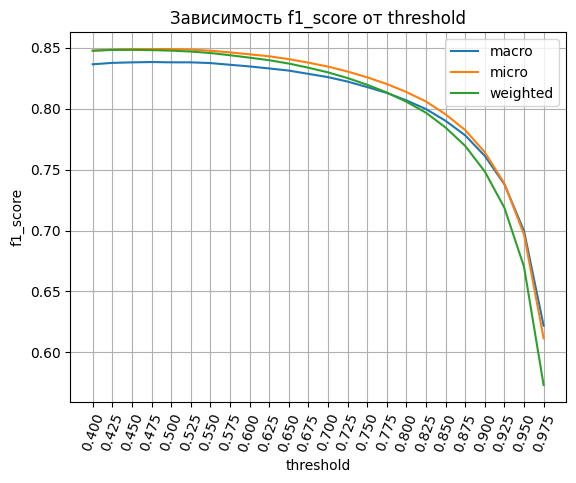

In [111]:
plt.plot(treshold_list, f1_score_macro_list, label = "macro")
plt.plot(treshold_list, f1_score_micro_list, label = "micro")
plt.plot(treshold_list, f1_score_weighted_list, label = "weighted")
plt.xticks(treshold_list, rotation=70)
plt.title("Зависимость f1_score от threshold")
plt.xlabel("threshold")
plt.ylabel("f1_score")
plt.legend()
plt.grid();

In [129]:
torch.tensor(f1_score_micro_list).numpy()

array([0.8473504 , 0.8483144 , 0.848753  , 0.8488376 , 0.84875596,
       0.8483132 , 0.8474669 , 0.8460611 , 0.84449655, 0.8428609 ,
       0.8405435 , 0.83765954, 0.8344217 , 0.83038026, 0.82564193,
       0.8201318 , 0.81358916, 0.80582255, 0.7953027 , 0.7823583 ,
       0.7642076 , 0.7385201 , 0.6967439 , 0.6116243 ], dtype=float32)

In [130]:
max_index = np.argmax(torch.tensor(f1_score_macro_list).numpy() +\
                      torch.tensor(f1_score_micro_list).numpy() +\
                      torch.tensor(f1_score_weighted_list).numpy())
print("best treshold:", treshold_list[max_index])
print("max f1_score_macro:", f1_score_macro_list[max_index])
print("max f1_score_micro:", f1_score_micro_list[max_index])
print("max f1_score_weighted:", f1_score_weighted_list[max_index])



best treshold: 0.47500000000000003
max f1_score_macro: tensor(0.8382)
max f1_score_micro: tensor(0.8488)
max f1_score_weighted: tensor(0.8479)


In [112]:
list_of_number_of_non_desided = []

for threshold in tqdm(treshold_list):
    list_of_number_of_non_desided.append(sum([sum(el < threshold) == len(el) for el in pred_res]))


100%|██████████| 24/24 [03:50<00:00,  9.58s/it]


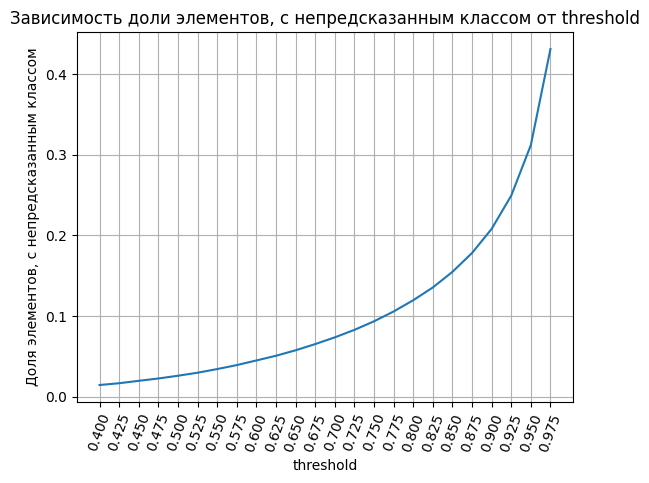

In [113]:
plt.plot(treshold_list, np.array(list_of_number_of_non_desided)/len(pred_res))
plt.xticks(treshold_list, rotation=70)
plt.xlabel("threshold")
plt.ylabel("Доля элементов, с непредсказанным классом")
plt.title("Зависимость доли элементов, с непредсказанным классом от threshold")
plt.grid();

In [132]:
(np.array(list_of_number_of_non_desided)/len(pred_res) )[max_index] 

0.02252336279884224

In [157]:
import time

In [162]:
start_time = time.time()
make_predictions_3(merged_model_multilabel, dataset_test_v2.select(range(100)) , "cpu")
result_time = time.time() - start_time

100%|██████████| 100/100 [01:46<00:00,  1.06s/it]


In [163]:
result_time / 100

1.0602995109558107